# ml zoomcamp
## week 4 homework
## Topic: Evaluation Metrics for Classification
### name: Isaac Muturi
### email: ndirangumuturi749@gmail.com


In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with `wget`:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```

In [2]:
'''import wget

url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'

filename = 'car.csv'

wget.download(url, filename)'''

"import wget\n\nurl = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'\n\nfilename = 'car.csv'\n\nwget.download(url, filename)"

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`

In [3]:
import pandas as pd

# Load the dataset
data = pd.read_csv('car.csv')

# Select the columns of interest
selected_columns = [
    'Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders',
    'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP'
]

df = data[selected_columns]


### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [4]:
# Lowercase the column names and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Fill the missing values with 0
df = df.fillna(0)

# Make the price binary (1 if above the average, 0 otherwise)
df['above_average'] = (df['msrp'] > df['msrp'].mean()).astype(int)

# Split the data into train/validation/test with a 60%/20%/20% distribution
X = df.drop(columns=['msrp', 'above_average'])
y = df['above_average']

from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [5]:
from sklearn.metrics import roc_auc_score

# Calculate ROC AUC for each numerical variable
numerical_vars = X.select_dtypes(include=['number']).columns.tolist()
auc_scores = {}

for var in numerical_vars:
    auc = roc_auc_score(y_train, X_train[var])
    # If AUC is < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[var])
    auc_scores[var] = auc

# Find the numerical variable with the highest AUC
highest_auc_var = max(auc_scores, key=auc_scores.get)
print("Numerical variable with the highest AUC:", highest_auc_var)


Numerical variable with the highest AUC: engine_hp


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979


In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Initialize DictVectorizer
vectorizer = DictVectorizer(sparse=False)

# Convert DataFrame to a list of dictionaries
X_train_dict = X_train.to_dict(orient='records')
X_val_dict = X_val.to_dict(orient='records')


# Transform categorical features using DictVectorizer (for training set)
X_train_encoded = vectorizer.fit_transform(X_train_dict)

# Transform categorical features using DictVectorizer (for validation set)
X_val_encoded = vectorizer.transform(X_val_dict)

# Initialize and train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train_encoded, y_train)

# Predict probabilities on the validation set
y_pred_proba = model.predict_proba(X_val_encoded)[:, 1]

# Calculate the AUC on the validation set
auc = roc_auc_score(y_val, y_pred_proba)

# Round the AUC to 3 decimal digits
rounded_auc = round(auc, 3)

# Print the rounded AUC
print("AUC on the validation dataset:", rounded_auc)


AUC on the validation dataset: 0.979


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88


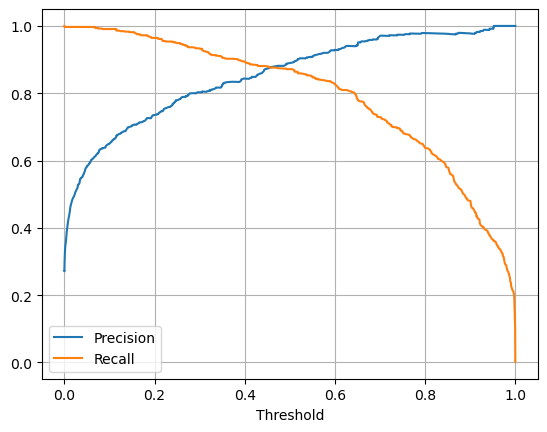

In [7]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

# Plot precision and recall curves
import matplotlib.pyplot as plt

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\ndira\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


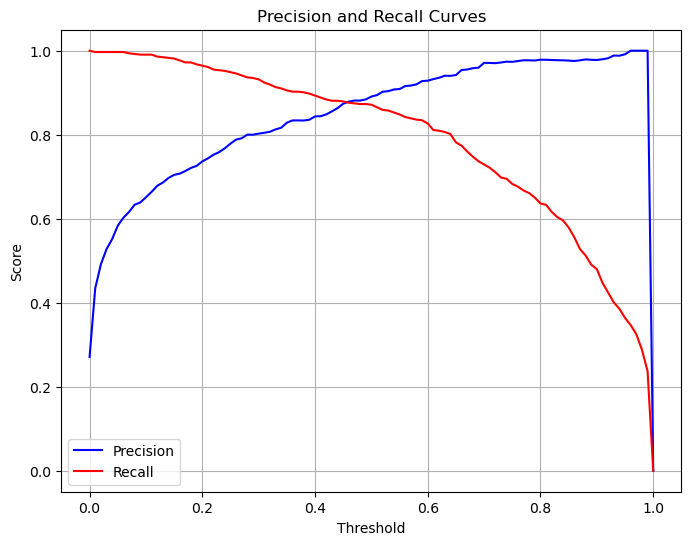

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score
# Calculate precision and recall for each threshold
thresholds = np.arange(0, 1.01, 0.01)
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred_binary = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y_val, y_pred_binary)
    recall = recall_score(y_val, y_pred_binary)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Plot precision and recall curves
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_scores, label='Precision', color='blue')
plt.plot(thresholds, recall_scores, label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Curves')
plt.legend()
plt.grid(True)
plt.show()


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

In [11]:
from sklearn.metrics import f1_score

# Calculate F1 score for each threshold
f1_scores = []

for threshold in thresholds:
    y_pred_binary = (y_pred_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred_binary)
    f1_scores.append(f1)

# Find the threshold at which F1 is maximal
max_f1_threshold = thresholds[np.argmax(f1_scores)]
print("Threshold with maximal F1:", max_f1_threshold)


Threshold with maximal F1: 0.5


In [12]:
from sklearn.metrics import precision_score, recall_score

# Calculate F1 score for each threshold
f1_scores = []

for threshold in thresholds:
    y_pred_binary = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y_val, y_pred_binary)
    recall = recall_score(y_val, y_pred_binary)
    f1 = 2 * (precision * recall) / (precision + recall)
    f1_scores.append(f1)

# Find the threshold at which F1 is maximal
max_f1_threshold = thresholds[np.argmax(f1_scores)]
print("Threshold with maximal F1:", max_f1_threshold)


Threshold with maximal F1: 1.0


c:\Users\ndira\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-12-6023bb702dc5>:10: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * (precision * recall) / (precision + recall)


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# Combine the training and validation sets to create df_full_train
df_full_train = pd.concat([X_train, X_val])
df_full_train['above_average'] = pd.concat([y_train, y_val])

# Separate features and target variable for df_full_train
X_full_train = df_full_train.drop(columns=['above_average'])
y_full_train = df_full_train['above_average']

# Initialize KFold with 5 splits and other parameters
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize a list to store AUC scores
auc_scores = []

# Initialize DictVectorizer
dv = DictVectorizer(sparse=False)

# Iterate over different folds
for train_idx, val_idx in kf.split(df_full_train):
    # Split the data into train and validation sets
    train_data, val_data = df_full_train.iloc[train_idx], df_full_train.iloc[val_idx]

    # Separate features and target variable for train and validation sets
    X_train_fold = train_data.drop(columns=['above_average'])
    y_train_fold = train_data['above_average']
    X_val_fold = val_data.drop(columns=['above_average'])
    y_val_fold = val_data['above_average']

    # Transform categorical features using DictVectorizer
    X_train_encoded = dv.fit_transform(X_train_fold.to_dict(orient='records'))
    X_val_encoded = dv.transform(X_val_fold.to_dict(orient='records'))

    # Initialize and train the logistic regression model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_encoded, y_train_fold)

    # Predict probabilities on the validation set
    y_pred_proba = model.predict_proba(X_val_encoded)[:, 1]

    # Calculate AUC score for this fold
    auc = roc_auc_score(y_val_fold, y_pred_proba)
    auc_scores.append(auc)

# Calculate the standard deviation of AUC scores
std_dev = np.std(auc_scores)
print("Standard deviation of AUC scores:", round(std_dev, 3))


Standard deviation of AUC scores: 0.004


### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [15]:
# Define a list of C values to iterate over
C_values = [0.01, 0.1, 0.5, 10]

# Initialize KFold with 5 splits and other parameters
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize dictionaries to store mean scores and std scores for each C
mean_scores = {}
std_scores = {}

# Initialize DictVectorizer
dv = DictVectorizer(sparse=False)

# Iterate over different C values
for C in C_values:
    # Initialize a list to store AUC scores for this C value
    auc_scores = []

    # Iterate over different folds
    for train_idx, val_idx in kf.split(df_full_train):
        # Split the data into train and validation sets
        train_data, val_data = df_full_train.iloc[train_idx], df_full_train.iloc[val_idx]

        # Separate features and target variable for train and validation sets
        X_train_fold = train_data.drop(columns=['above_average'])
        y_train_fold = train_data['above_average']
        X_val_fold = val_data.drop(columns=['above_average'])
        y_val_fold = val_data['above_average']

        # Transform categorical features using DictVectorizer
        X_train_encoded = dv.fit_transform(X_train_fold.to_dict(orient='records'))
        X_val_encoded = dv.transform(X_val_fold.to_dict(orient='records'))

        # Initialize and train the logistic regression model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_encoded, y_train_fold)

        # Predict probabilities on the validation set
        y_pred_proba = model.predict_proba(X_val_encoded)[:, 1]

        # Calculate AUC score for this fold
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)

    # Calculate the mean and standard deviation of AUC scores for this C value
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    # Store the mean and std scores for this C value in dictionaries
    mean_scores[C] = round(mean_auc, 3)
    std_scores[C] = round(std_auc, 3)

# Find the best C value based on mean scores and std scores
best_C = min(mean_scores, key=lambda x: (mean_scores[x], std_scores[x], x))
print("Best C value:", best_C)


Best C value: 0.01





















## Submit the results

- Submit your results here: https://forms.gle/E7Fa3WuBw3HkPQYg6
- If your answer doesn't match options exactly, select the closest one.
- You can submit your solution multiple times. In this case, only the last submission will be used

## Deadline

The deadline for submitting is October 9 (Monday), 23:00 CET. After that the form will be closed.
